In [56]:
from numpy.core.arrayprint import format_float_positional
from zoltpy import util, connection
from qenspy import qens
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

In [58]:
# Download example forecast data from Zoltar
conn = util.authenticate()
project_name = 'COVID-19 Forecasts'

In [59]:
def query_project_forecasts_and_truth(conn, project_name, models, units, targets, timezeros, types):
  """Query forecasts and corresponding observed truth from Zoltar."""
  query = {
    "models": models,
    "units": units,
    "targets": targets,
    "timezeros": timezeros,
    "types": types}
  forecasts = util.query_project(conn, project_name, connection.QueryType.FORECASTS, query) \
    .assign(
      timezero = lambda x: pd.to_datetime(x.timezero),
      forecast_date = lambda x: x.timezero +
        x.timezero.dt.dayofweek.apply(lambda dow: pd.Timedelta(days = dow / 6)),
      value = lambda x: x.value.astype('float64')
    ) \
    [['model', 'unit', 'forecast_date', 'target', 'quantile', 'value']]
  
  query = {
    "units": units,
    "targets": targets,
    "timezeros": timezeros}
  truth = util.query_project(conn, project_name, connection.QueryType.TRUTH, query) \
    .assign(
      timezero = lambda x: pd.to_datetime(x.timezero),
      forecast_date = lambda x: x.timezero +
        x.timezero.dt.dayofweek.apply(lambda dow: pd.Timedelta(days = dow / 6)),
      value = lambda x: x.value.astype('float64')
    ) \
    [['unit', 'forecast_date', 'target', 'value']]
  
  return (forecasts, truth.drop_duplicates())

In [60]:
def q_df_to_array(q_df, tau_strs, models):
  """Convert predictive quantiles from a tidy data frame to a 3d array."""
  q_wide = q_df \
    .set_index(keys = ['unit', 'forecast_date', 'target', 'model', 'quantile']) \
    [['value']] \
    .unstack(['model', 'quantile'])
  model_cols = q_wide.columns.get_level_values(1)
  
  def model_q_ordered(model):
    df_one_model = q_wide.iloc[:, model_cols == model].droplevel([0, 1], axis = 1)
    return df_one_model[tau_strs].values
  
  q_arr = np.concatenate(
    [model_q_ordered(model)[..., np.newaxis] for model in models],
    axis = 2
  )
  
  return q_arr

In [61]:
def plot_forecasts(
  q,
  y,
  models,
  tau):
  """Plot observations and predictions."""
  fig, ax = plt.subplots(nrows=(len(models) + 1)//2, ncols=2, figsize=(12, 30))
  fig.set_tight_layout(True)
  
  interval_colors = ['#a6bddb', '#74a9cf', '#3690c0', '#0570b0']
  interval_labels = ['98%', '95%', '80%', '50%']
  
  for m in range(len(models)):
    row_ind = m // 2
    col_ind = m % 2
    
    ax[row_ind, col_ind].grid()
    ax[row_ind, col_ind].set_axisbelow(True)
    ax[row_ind, col_ind].set(
      xticks=np.linspace(1, 4, 4),
      xlabel='Forecast Horizon',
      ylabel='',
      title=models[m])
    #ax[row_ind, col_ind].yaxis.set_major_formatter(mtick.StrMethodFormatter('{:s}')) #%8d
    ax[row_ind, col_ind].yaxis.set_major_formatter(mtick.FormatStrFormatter('%8d')) #
    #ax[row_ind, col_ind].text(0,1,models[m],ha='right',va='top',transform=ax[row_ind, col_ind].transAxes,weight='bold')
    
    # Prediction intervals
    for interval_ind, half_alpha in enumerate([0.01, 0.025, 0.1, 0.25]):
      k_lower = np.where(abs(tau - half_alpha) < 1e-7)
      k_upper = np.where(abs(tau - (1 - half_alpha)) < 1e-7)
      ax[row_ind, col_ind].fill_between(
        np.linspace(1, 4, 4),
        q[:, k_lower, m].reshape(4),
        q[:, k_upper, m].reshape(4),
        color = interval_colors[interval_ind],
        label = interval_labels[interval_ind])
    
    # train set data
    ax[row_ind, col_ind].plot(
        np.linspace(1, 4, 4),
        y,
        'orange',
        label = "Observed")
    
    # plot predictive median
    k_median = np.where(abs(tau - 0.5) < 1e-7)
    ax[row_ind, col_ind].plot(
        np.linspace(1, 4, 4),
        q[:, k_median, m].reshape(4),
        '#034e7b',
        ls='--',
        lw=3.0,
        label = "Forecast")
    
    if m == 0:
      ax[row_ind, col_ind].legend(loc='upper right', ncol=3)
  
  plt.show()

In [62]:
# load forecasts and data from Zoltar
models = ["epiforecasts-ensemble1", "LNQ-ens1", "UMass-MechBayes"]
units = ["39"]
targets = [str(h + 1) + ' wk ahead inc death' for h in range(4)]
types = ["quantile"]
train_timezeros = ['2021-01-17', '2021-01-18', '2021-01-24', '2021-01-25',
  '2021-01-31', '2021-02-01', '2021-02-07', '2021-02-08']
test_timezeros = ['2021-02-14', '2021-02-15']

In [63]:
tau_strs = ['0.01', '0.025']
tau_strs.extend(
  [np.format_float_positional(x, 2) for x in np.linspace(0.05, 0.95, 19)])
tau_strs.extend(['0.975', '0.99'])
tau = np.array(tau_strs).astype('float64')


In [64]:
(train_forecasts, train_truth) = query_project_forecasts_and_truth(
  conn=conn,
  project_name=project_name,
  models=models,
  units=units,
  targets=targets,
  timezeros=train_timezeros,
  types=types)


* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/52672/', 52672)
- QUEUED
- QUEUED
- SUCCESS

* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/52673/', 52673)
- QUEUED
- QUEUED
- SUCCESS


In [65]:
(test_forecasts, test_truth) = query_project_forecasts_and_truth(
  conn=conn,
  project_name=project_name,
  models=models,
  units=units,
  targets=targets,
  timezeros=test_timezeros,
  types=types)



* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/52674/', 52674)
- QUEUED
- SUCCESS

* polling for status change. job: ('Job', 'https://zoltardata.com/api/job/52675/', 52675)
- QUEUED
- SUCCESS


In [66]:
q_train = q_df_to_array(train_forecasts, tau_strs, models)
y_train = train_truth['value'].values


In [67]:
q_test = q_df_to_array(test_forecasts, tau_strs, models)
y_test = test_truth['value'].values

In [68]:
# illustrate calculation of equal-weighted mean ensemble
K = len(tau)
M = len(models)

In [69]:
w_equal = np.full((K, M), 1./M)
q_equal_mean = qens.MeanQEns().predict(q_test, w=w_equal)

In [70]:
# make a plot
q_combined = np.concatenate([q_test, q_equal_mean[..., np.newaxis]], axis = 2)
models_combined = models.copy()
models_combined.append('Equal weighted mean ensemble')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


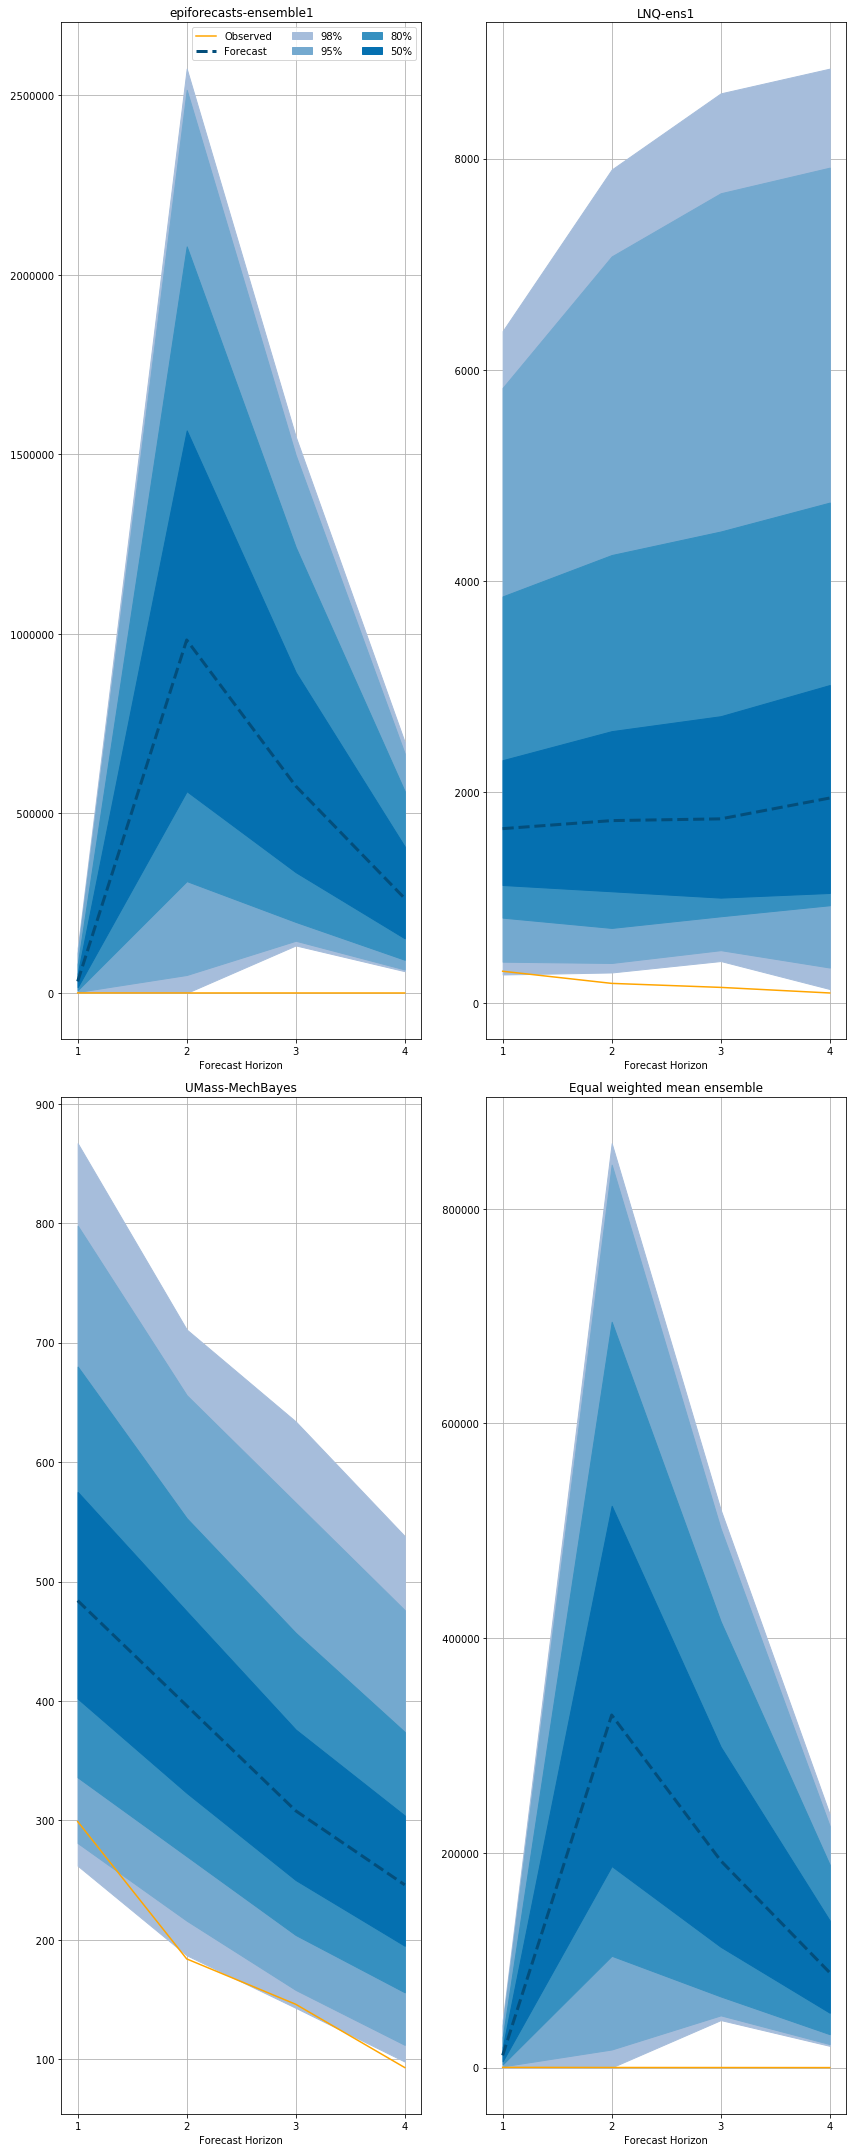

In [71]:
plot_forecasts(
  q = q_combined,
  y = y_test,
  models = models_combined,
  tau = tau)

In [72]:
# illustrate calculation of unequal-weighted mean ensemble
w = np.repeat([[0.1, 0.1, 0.8]],K, axis=0)
q_mean = qens.MeanQEns().predict(q_test, w=w)

In [73]:
# make a plot
q_combined = np.concatenate([q_test, q_mean[..., np.newaxis]], axis = 2)
models_combined = models.copy()
models_combined.append('Weighted mean ensemble')

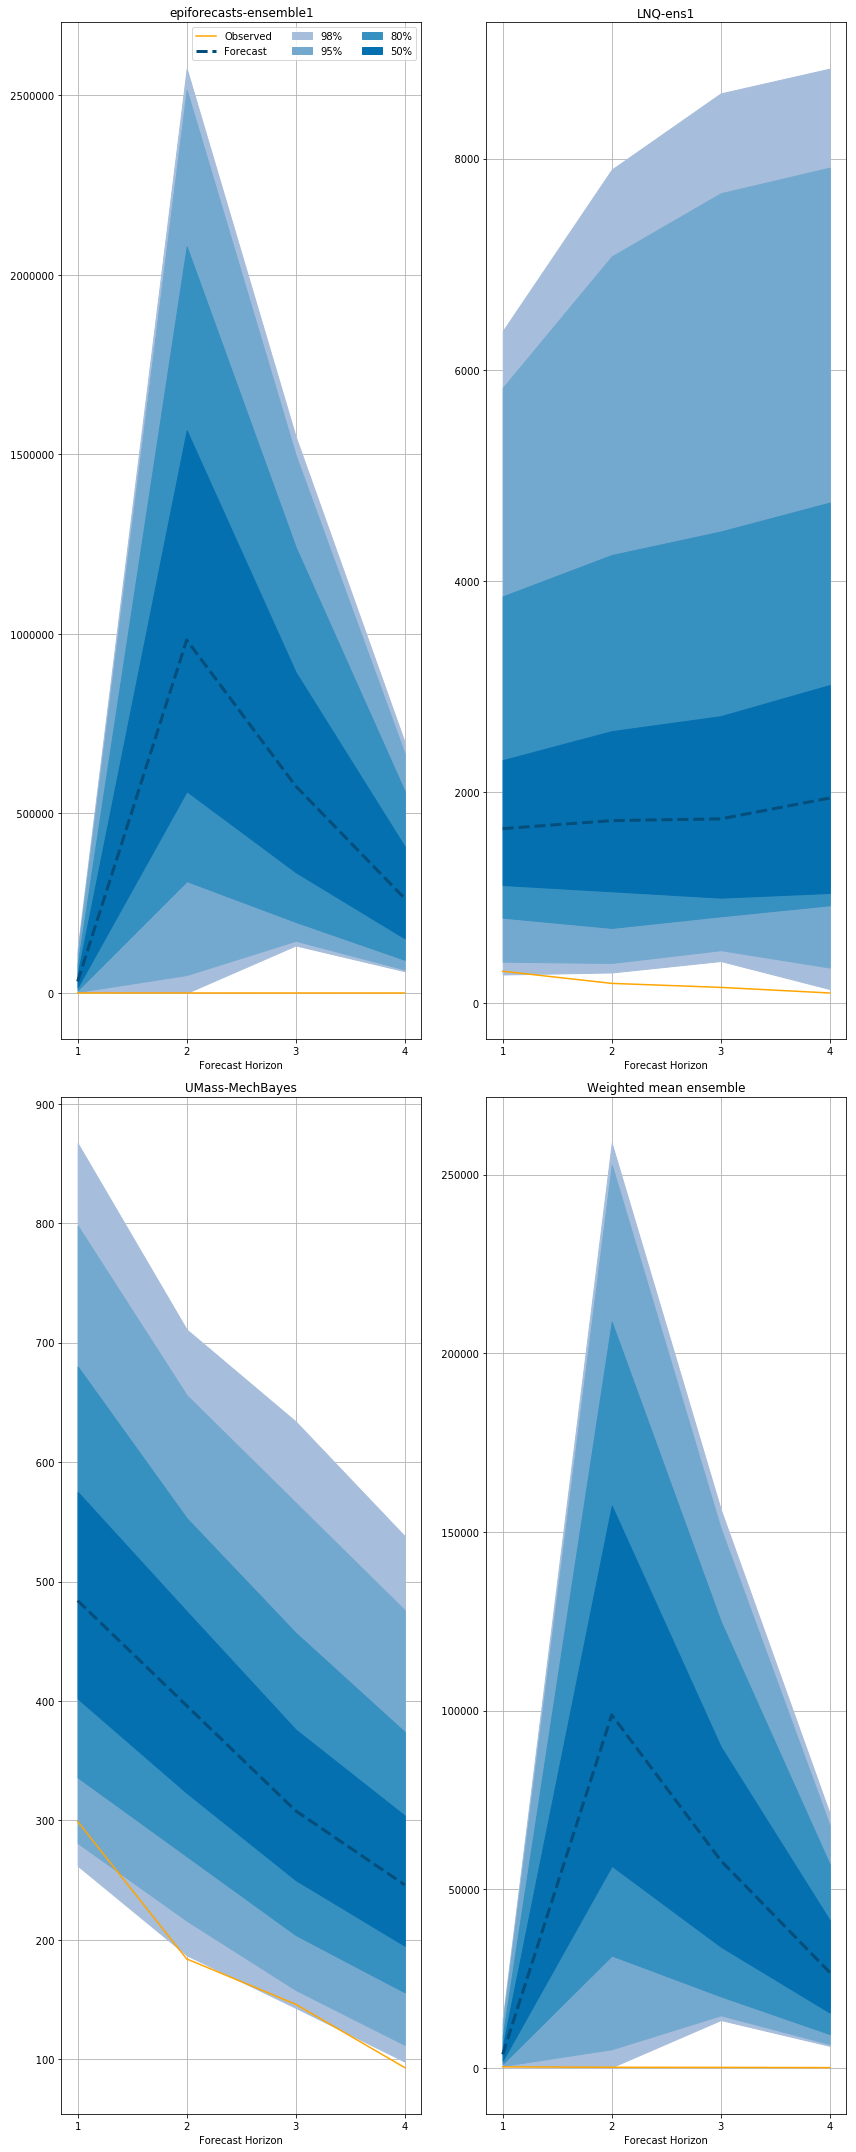

In [74]:
plot_forecasts(
  q = q_combined,
  y = y_test,
  models = models_combined,
  tau = tau)